Εισαγωγή χρήσιμων Βιβλιοθηκών

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist
from keras import backend as K
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.initializers import Initializer
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score,mean_squared_error
import math
from sklearn.metrics import pairwise
import tensorflow_addons as tfa
import keras_tuner as kt

2022-03-07 15:49:51.692014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 15:49:51.692039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Εισαγωγή, κανονικοποίηση δεδομένων

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.25)

#Convert to float32
x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)
y_train, y_test = np.array(y_train, dtype=np.float32), np.array(y_test, dtype=np.float32)

x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

Δημιουργία RBF επιπέδου και initializer με k-means.
            RBFLayer: Available at https://github.com/PetraVidnerova/rbf_keras 
            (τροποποιημένο καθώς δεν υπήρχε ο συντελεστής σ)

In [3]:
class InitCentersKMeans(Initializer):

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_        

class RBFLayer(Layer):

    def __init__(self, output_dim, initializer=None, sigma=1.0, **kwargs):
        self.init_sigma = sigma
        self.output_dim = output_dim
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.sigma = self.add_weight(name='sigmas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_sigma),
                                     trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-(1/(2*(self.sigma**2))) * K.sum(H**2, axis=1))
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Χρήσιμες επιλογές

In [4]:
layers_neurons = [round(0.1*x_train.shape[0]), round(0.5*x_train.shape[0]), round(0.9*x_train.shape[0])]

optimizer = keras.optimizers.SGD(learning_rate=0.001)
loss = keras.losses.MeanSquaredError()
metrics = ['accuracy']
epochs = 100
out_n = 128
validation_split = 0.2

Δημιουργία, εκπαίδευση μοντέλων και υπολογισμός καμπύλης εκμάθησης και μετρηκών R^2, RMSE

2022-03-07 15:49:54.979446: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-07 15:49:54.979494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: alepetpanelementary
2022-03-07 15:49:54.979503: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: alepetpanelementary
2022-03-07 15:49:54.979631: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.144.0
2022-03-07 15:49:54.979662: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.144.0
2022-03-07 15:49:54.979669: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 390.144.0
2022-03-07 15:49:54.980146: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

Epoch 1/100
10/10 [==============================] - 1s 28ms/step - loss: 359.2922 - accuracy: 0.0000e+00 - val_loss: 198.5737 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 76.8969 - accuracy: 0.0000e+00 - val_loss: 119.4681 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 65.1122 - accuracy: 0.0000e+00 - val_loss: 121.1874 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 62.4165 - accuracy: 0.0000e+00 - val_loss: 126.7359 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 60.8032 - accuracy: 0.0000e+00 - val_loss: 108.7678 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 57.2412 - accuracy: 0.0000e+00 - val_loss: 116.0540 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 55.5287 - acc

10/10 [==============================] - 0s 8ms/step - loss: 48.3745 - accuracy: 0.0000e+00 - val_loss: 108.0966 - val_accuracy: 0.0000e+00
Epoch 55/100
10/10 [==============================] - 0s 12ms/step - loss: 51.6509 - accuracy: 0.0000e+00 - val_loss: 114.6861 - val_accuracy: 0.0000e+00
Epoch 56/100
10/10 [==============================] - 0s 8ms/step - loss: 50.6463 - accuracy: 0.0000e+00 - val_loss: 105.5608 - val_accuracy: 0.0000e+00
Epoch 57/100
10/10 [==============================] - 0s 13ms/step - loss: 46.9852 - accuracy: 0.0000e+00 - val_loss: 119.0069 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 10ms/step - loss: 49.6816 - accuracy: 0.0000e+00 - val_loss: 111.8481 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 49.0681 - accuracy: 0.0000e+00 - val_loss: 113.4134 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 5ms/step - loss: 54.0139 - accuracy

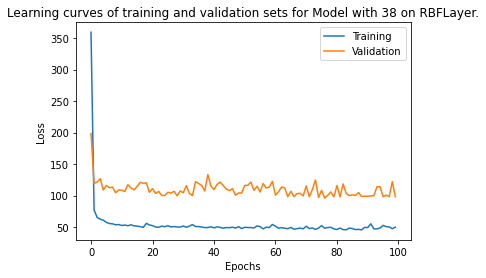

From predict:
R^2: 0.3763363825946291
RMSE: 6.881751057661771
Epoch 1/100
10/10 [==============================] - 1s 32ms/step - loss: 316.6047 - accuracy: 0.0000e+00 - val_loss: 149.1515 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 78.7410 - accuracy: 0.0000e+00 - val_loss: 132.8103 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 69.4411 - accuracy: 0.0000e+00 - val_loss: 117.4247 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 64.1357 - accuracy: 0.0000e+00 - val_loss: 115.6362 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 60.3058 - accuracy: 0.0000e+00 - val_loss: 113.7124 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 56.6417 - accuracy: 0.0000e+00 - val_loss: 118.2863 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [===

10/10 [==============================] - 0s 21ms/step - loss: 43.3952 - accuracy: 0.0000e+00 - val_loss: 100.9836 - val_accuracy: 0.0000e+00
Epoch 55/100
10/10 [==============================] - 0s 19ms/step - loss: 44.0496 - accuracy: 0.0000e+00 - val_loss: 102.3675 - val_accuracy: 0.0000e+00
Epoch 56/100
10/10 [==============================] - 0s 18ms/step - loss: 43.7205 - accuracy: 0.0000e+00 - val_loss: 136.2828 - val_accuracy: 0.0000e+00
Epoch 57/100
10/10 [==============================] - 0s 20ms/step - loss: 41.7520 - accuracy: 0.0000e+00 - val_loss: 104.6467 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 25ms/step - loss: 45.0398 - accuracy: 0.0000e+00 - val_loss: 94.8283 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 18ms/step - loss: 42.1213 - accuracy: 0.0000e+00 - val_loss: 108.3770 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 20ms/step - loss: 48.5503 - accur

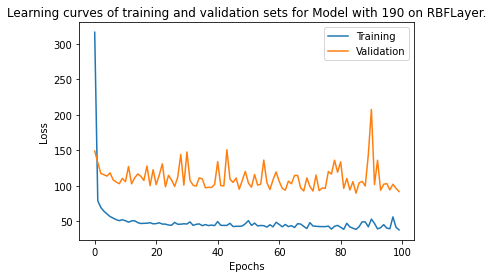

From predict:
R^2: 0.418220948838955
RMSE: 6.646649094344428
Epoch 1/100
10/10 [==============================] - 1s 20ms/step - loss: 332.4910 - accuracy: 0.0000e+00 - val_loss: 156.0424 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 82.0808 - accuracy: 0.0000e+00 - val_loss: 134.2898 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 70.3539 - accuracy: 0.0000e+00 - val_loss: 131.3697 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 63.4654 - accuracy: 0.0000e+00 - val_loss: 113.7449 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 60.4281 - accuracy: 0.0000e+00 - val_loss: 115.9017 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 55.6621 - accuracy: 0.0000e+00 - val_loss: 126.6906 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [======

10/10 [==============================] - 0s 8ms/step - loss: 40.0572 - accuracy: 0.0000e+00 - val_loss: 88.1248 - val_accuracy: 0.0000e+00
Epoch 55/100
10/10 [==============================] - 0s 6ms/step - loss: 37.7628 - accuracy: 0.0000e+00 - val_loss: 94.1960 - val_accuracy: 0.0000e+00
Epoch 56/100
10/10 [==============================] - 0s 7ms/step - loss: 42.5912 - accuracy: 0.0000e+00 - val_loss: 87.2000 - val_accuracy: 0.0000e+00
Epoch 57/100
10/10 [==============================] - 0s 7ms/step - loss: 39.7759 - accuracy: 0.0000e+00 - val_loss: 137.6221 - val_accuracy: 0.0000e+00
Epoch 58/100
10/10 [==============================] - 0s 6ms/step - loss: 37.6337 - accuracy: 0.0000e+00 - val_loss: 91.7251 - val_accuracy: 0.0000e+00
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 37.9243 - accuracy: 0.0000e+00 - val_loss: 94.3761 - val_accuracy: 0.0000e+00
Epoch 60/100
10/10 [==============================] - 0s 7ms/step - loss: 49.1469 - accuracy: 0.0000

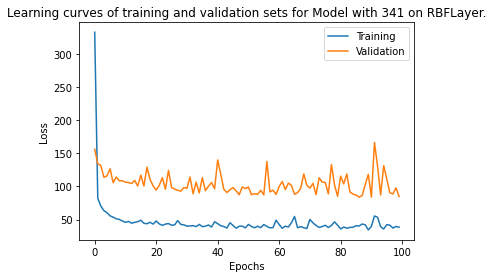

From predict:
R^2: 0.46477418219068756
RMSE: 6.375177418353038


In [5]:
for neuron in layers_neurons:
    kmeans = KMeans(n_clusters=neuron).fit(x_train)
    centers = kmeans.cluster_centers_
    dmax = np.amax(pdist(centers, 'euclidean'))
    sigma = dmax/tf.math.sqrt(2*float(centers.shape[0]))
    
    model = keras.models.Sequential() 
    model.add(RBFLayer(neuron, initializer=InitCentersKMeans(x_train), sigma=sigma, input_shape=(x_train.shape[1],)))
    model.add(keras.layers.Dense(out_n))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    fit = model.fit(x_train, y_train, epochs=epochs ,validation_split=validation_split, verbose=1)
    # Leaning Curve
    plt.figure()
    plt.plot(fit.history['loss'],label='Training')
    plt.plot(fit.history['val_loss'],label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss') 
    plt.legend()
    plt.title(f"Learning curves of training and validation sets for Model with {neuron} on RBFLayer.")
    plt.show()
    plt.close()
    
    y_pred = model.predict(x_test)
    
    print(f"From predict:\nR^2: {r2_score(y_test,y_pred)}\nRMSE: {math.sqrt(mean_squared_error(y_test,y_pred))}")

Fine Tuning

Συνάρτηση η οποία δημιουργεί και επιστρέφει ένα Keras μοντέλο.

In [6]:
def build_model(hp):
    
    n_h1 = hp.Choice('hidden1', 
                    [round(0.05*x_train.shape[0]), round(0.15*x_train.shape[0]), round(0.3*x_train.shape[0]), round(0.5*x_train.shape[0])])
    n_h2 = hp.Choice('hidden2', [32, 64, 128, 256])
    dp = hp.Choice('dp', [0.2, 0.35, 0.5])
    
    kmeans = KMeans(n_clusters=n_h1).fit(x_train)
    centers = kmeans.cluster_centers_
    dmax = np.amax(pdist(centers, 'euclidean'))
    sigma = dmax/tf.math.sqrt(2*float(centers.shape[0]))
    
    optimizer = keras.optimizers.SGD(learning_rate=0.001)
    metrics = ['accuracy',keras.metrics.RootMeanSquaredError()]

    model = keras.models.Sequential()
    model.add(RBFLayer(n_h1, initializer=InitCentersKMeans(x_train), sigma=sigma, input_shape=(13,)))
    model.add(keras.layers.Dense(n_h2))
    model.add(keras.layers.Dropout(dp))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model

Αρχικοποίηση ενός tuner

In [7]:
epochs = 100
objective=kt.Objective('val_accuracy', direction = 'max')

tuner = kt.Hyperband(build_model, objective=objective, max_epochs=epochs)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


Αναζήτηση βέλτιστων παραμέτρων

In [8]:
tuner.search(x_train, y_train, epochs=epochs, validation_split=validation_split)
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neurons in 1st (RBF) layer: {best_params.get('hidden1')}")
print(f"Optimal number of neurons in 2nd layer: {best_params.get('hidden2')}")
print(f"Optimal value of dropout probability: {best_params.get('dp')}")


INFO:tensorflow:Oracle triggered exit
Optimal number of neurons in 1st (RBF) layer: 19
Optimal number of neurons in 2nd layer: 128
Optimal value of dropout probability: 0.5


Εκπαίδευση του βέλτιστου Μοντέλου

Epoch 1/100
10/10 [==============================] - 1s 30ms/step - loss: 368.1064 - accuracy: 0.0000e+00 - root_mean_squared_error: 19.1861 - val_loss: 218.4423 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 14.7798
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 93.3471 - accuracy: 0.0000e+00 - root_mean_squared_error: 9.6616 - val_loss: 128.8473 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 11.3511
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 73.3349 - accuracy: 0.0000e+00 - root_mean_squared_error: 8.5636 - val_loss: 118.7356 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.8966
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 68.7658 - accuracy: 0.0000e+00 - root_mean_squared_error: 8.2925 - val_loss: 124.2646 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 11.1474
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 67.3450 - accuracy: 0.00

10/10 [==============================] - 0s 7ms/step - loss: 56.3190 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.5046 - val_loss: 124.1311 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 11.1414
Epoch 38/100
10/10 [==============================] - 0s 6ms/step - loss: 58.1252 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.6240 - val_loss: 100.5229 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.0261
Epoch 39/100
10/10 [==============================] - 0s 8ms/step - loss: 53.7749 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.3331 - val_loss: 104.5939 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.2271
Epoch 40/100
10/10 [==============================] - 0s 7ms/step - loss: 62.1395 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.8829 - val_loss: 113.8199 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.6686
Epoch 41/100
10/10 [==============================] - 0s 7ms/step - loss: 58.4785 - accuracy: 0.0000e+00 - ro

10/10 [==============================] - 0s 10ms/step - loss: 54.0997 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.3552 - val_loss: 99.7961 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 9.9898
Epoch 74/100
10/10 [==============================] - 0s 9ms/step - loss: 52.7924 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.2658 - val_loss: 101.2100 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.0603
Epoch 75/100
10/10 [==============================] - 0s 11ms/step - loss: 61.5654 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.8464 - val_loss: 101.2568 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.0626
Epoch 76/100
10/10 [==============================] - 0s 9ms/step - loss: 53.3185 - accuracy: 0.0000e+00 - root_mean_squared_error: 7.3020 - val_loss: 103.6429 - val_accuracy: 0.0000e+00 - val_root_mean_squared_error: 10.1805
Epoch 77/100
10/10 [==============================] - 0s 8ms/step - loss: 58.1042 - accuracy: 0.0000e+00 - ro

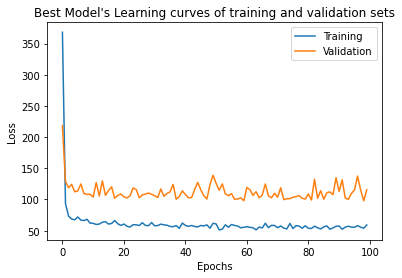

From predict:
R^2: 0.3035928065950315
RMSE: 7.272024966055438


In [9]:
model = tuner.hypermodel.build(best_params)
fit = model.fit(x_train, y_train, epochs=epochs, validation_split=validation_split)

plt.figure()
plt.plot(fit.history['loss'],label='Training')
plt.plot(fit.history['val_loss'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.title("Best Model's Learning curves of training and validation sets")
plt.show()
plt.close()

y_pred = model.predict(x_test)
    
print(f"From predict:\nR^2: {r2_score(y_test,y_pred)}\nRMSE: {math.sqrt(mean_squared_error(y_test,y_pred))}")